In [0]:
# Mounting your drive. Make sure to UNCHECK "Reset All Runtimes and then click on run anyway" - 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np

# To store data
import pandas as pd

# To open zipped files
import bz2

# To use regular expressions
import re

#To load and save data
import pickle

**Don't Run the following code if you want to only evaluate the model... You need to run the only last section of the code.**

In [0]:
# Load Preprocessed train review and doing some data analysis : Trianing Data 
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/preprocessed_train_review_sentences.pkl .

In [0]:
#import pickle
with open('preprocessed_train_review_sentences.pkl', 'rb') as f:
    train_review_sentences = pickle.load(f)

In [0]:
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/train_review_labels.pkl .

In [0]:
with open('train_review_labels.pkl', 'rb') as f:
    train_review_labels = pickle.load(f)

In [0]:
train_reviews_df = pd.DataFrame(
    {'review': train_review_sentences,
     'label': train_review_labels,
    })

In [0]:
# Analyzing data via dataframe operations
train_reviews_df.head()

,review,label
0,stuning even non-gamer: sound track beautiful!...,1
1,best soundtrack ever anything.: i'm reading lo...,1
2,"amazing!: soundtrack favorite music time, hand...",1
3,excellent soundtrack: truly like soundtrack en...,1
4,"remember, pull jaw floor hearing it: played ga...",1


In [0]:
train_reviews_df.tail()

,review,label
3599995,it!!: high chair looks great first comes box h...,0
3599996,"looks nice, low functionality: used highchair ...",0
3599997,"compact, hard clean: small house, really wante...",0
3599998,saying?: sure book supposed be. really rehash ...,0
3599999,makes blood run red-white-and-blue: agree ever...,1


In [0]:
train_reviews_df.describe() # Ensures we have only values between 0,1

,label
count,3600000.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [0]:

train_reviews_df['label'].value_counts()
# Ensures we have only 2 labels positive and negetive
# Shows that we have equal number of positive and negetive reviews. So no skewness in data. We have equal number of samples which is a good thing

1    1800000
0    1800000
Name: label, dtype: int64

In [0]:
# Use Tokenizer to remove punctuations and non-word characters and tokenize the text
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 8000 # This specifies how many top tokens in each review to be stored. Wrongly interpreted as total number of words(token) together in whole dataset
EMBEDDING_DIM = 100
#VALIDATION_SPLIT = 0.2

In [0]:
# Loading Tokenized padded sequences to feed to ML model

!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/Tokenized_Padded_Train_Sequence.pkl .
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/Tokenized_Padded_Test_Sequence.pkl .

In [0]:
with open('Tokenized_Padded_Train_Sequence.pkl', 'rb') as f:
    train_reviews_padded = pickle.load(f)
    # Loading test sequences
with open('Tokenized_Padded_Test_Sequence.pkl', 'rb') as f:
    test_reviews_padded = pickle.load(f)

In [0]:
train_reviews_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   15,  520,
       6357,   85,  395,  274, 6043,  351,   13,    7, 1775,   15,   54,
        589,   63,   40,  433,   63, 1812,  506,   51,  433,   20,   40,
       6645,  145, 5067,  334,  775, 2977, 4299,    7, 5165,  111, 2677,
        243], dtype=int32)

In [0]:
# Loading the word_embedding matrix
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/WordEmbeddingMappingMatrix.pkl . 

In [0]:
with open('WordEmbeddingMappingMatrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

In [0]:
# Loading the word_index
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/Word_Index.pkl .

In [0]:
with open('Word_Index.pkl', 'rb') as f:
    word_index = pickle.load(f)

In [0]:
# Loading the training labels
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/train_review_labels.pkl .

In [0]:
# Loading test labels
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/test_review_labels.pkl .

In [0]:
with open('train_review_labels.pkl', 'rb') as f:
    train_review_labels = pickle.load(f)

In [0]:
# Opening Test labels
with open('test_review_labels.pkl', 'rb') as f:
    test_review_labels = pickle.load(f)

In [0]:
len(train_review_labels),len(train_reviews_padded),train_reviews_padded.shape

(3600000, 3600000, (3600000, 100))

In [0]:
len(test_review_labels),len(test_reviews_padded),test_reviews_padded.shape

(400000, 400000, (400000, 100))

In [0]:
from keras.models import Sequential,Model
from keras.layers import Dense, Embedding,Input,Dropout,BatchNormalization,Activation,LSTM
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [0]:
embedded_sequences = embedding_layer(sequence_input)

Instructions for updating:
Colocations handled automatically by placer.


Building the LSTM architecture with Embedding Layer followed by 3 LSTM layers of 80 units each.
In the end, Dense layer with 2 layers for output : Softmax as activation functions

In [0]:
net = Dropout(0.5)(embedded_sequences)
net = LSTM(80,dropout=0.5,return_sequences=True)(net)
net = LSTM(80,dropout=0.5,return_sequences=True)(net)
net = LSTM(80,dropout=0.5)(net)
net = Dense(2)(net)
output = Activation('softmax')(net)
model = Model(inputs = sequence_input, outputs = output)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          99649800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 80)           57920     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 80)           51520     
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                51520     
___________________________

Model name convenction : sizeOfLSTM ... Activation....Training Data....embedding = True

In [0]:
model_name = 'LSTM_80_80_80_softmax_100000_true'

In [0]:
history = model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
x_train = np.array(train_reviews_padded)
y_train = np.array(train_review_labels)

In [0]:
len(x_train),len(y_train)

(3600000, 3600000)

In [0]:
x_train = np.array(x_train[:1000000])
train_labels = [[1,0] if x == 0 else [0,1] for x in y_train[:1000000]] 
y_train = np.array(train_labels)
len(x_train),len(y_train)

(1000000, 1000000)

In [0]:
y_train[0]

array([0, 1])

In [0]:
train_labels[0]
y_train = np.array(train_labels)

In [0]:
len(x_train),len(y_train)

(1000000, 1000000)

In [0]:
model_history = model.fit(x_train, y_train, batch_size=2048, epochs=5, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 900000 samples, validate on 100000 samples
Epoch 1/5
900000/900000 [==============================] - 5149s 6ms/step - loss: 0.4085 - acc: 0.8076 - val_loss: 0.2738 - val_acc: 0.8880
Epoch 2/5
900000/900000 [==============================] - 5065s 6ms/step - loss: 0.2862 - acc: 0.8795 - val_loss: 0.2644 - val_acc: 0.8951
Epoch 3/5
900000/900000 [==============================] - 4900s 5ms/step - loss: 0.2669 - acc: 0.8892 - val_loss: 0.2499 - val_acc: 0.9006
Epoch 4/5
900000/900000 [==============================] - 4983s 6ms/step - loss: 0.2568 - acc: 0.8941 - val_loss: 0.2459 - val_acc: 0.9003
Epoch 5/5
900000/900000 [==============================] - 5013s 6ms/step - loss: 0.2488 - acc: 0.8974 - val_loss: 0.2339 - val_acc: 0.9062


In [0]:
# Saving the model so that it can be loaded easily again
model.save_weights('rnn_model_weights_80_80_80_true.h5')

# Save the model architecture
with open('rnn_model_architecture_80_80_80_true.json', 'w') as f:
    f.write(model.to_json())

In [0]:
# Run following code only if you train the model 
# !cp rnn_model_weights_80_80_80_true.h5 gdrive/My\ Drive/ADBI-Submission/RNN/Result
# !cp rnn_model_architecture_80_80_80_true.json gdrive/My\  Drive/ADBI-Submission/RNN/Result


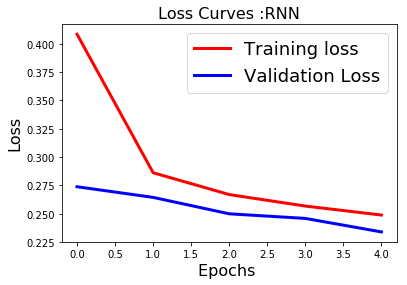

In [0]:
# Run the following code only if you train the model
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

# Loss Curves

fig1 = plt.figure()
plt.plot(model_history.history['loss'],'r',linewidth=3.0)
plt.plot(model_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn_80_80_80_true.png')
plt.show()

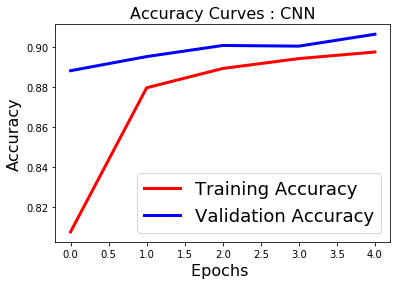

In [0]:
# Run the following code only if you train the model
# Accuracy Curves
fig2=plt.figure()
plt.plot(model_history.history['acc'],'r',linewidth=3.0)
plt.plot(model_history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn_80_80_80_true.png')
plt.show()

Plotting Model Architecture

In [0]:
# Run the following code only if you train the model
from keras.utils import plot_model
plot_model(model, to_file='rnn_model_diagram_new.png',show_shapes=True, show_layer_names=True)

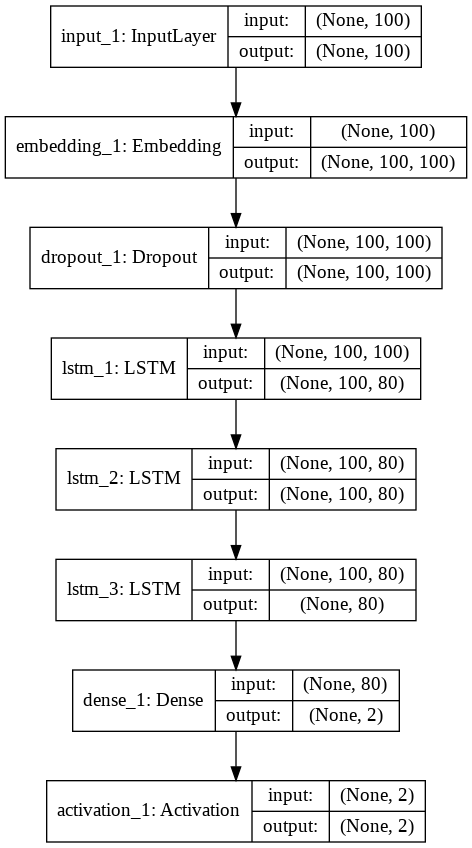

In [0]:
# Run the following code only if you train the model
# Displaying visual graph of the RNN Model
from PIL import Image
display(Image.open('rnn_model_diagram_new.png'))

Model Evaluation and Testing

**Run the Following code for Model Evaluation. .....................Loading the trained model and evaluating on Test Data**

In [0]:
!cp gdrive/My\ Drive/ADBI-Submission/RNN/Result/rnn_model_weights_80_80_80_true.h5 .
!cp gdrive/My\ Drive/ADBI-Submission/RNN/Result/rnn_model_architecture_80_80_80_true.json .

In [0]:
# Loading model and weights again from drive
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('rnn_model_architecture_80_80_80_true.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('rnn_model_weights_80_80_80_true.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          99649800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 80)           57920     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 80)           51520     
_________________________________________________________________
lstm_3 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 162       
__________

In [0]:
# Loading test labels and reviews
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/test_review_labels.pkl .
!cp gdrive/My\ Drive/ADBI-Submission/Preprocessing/Data/Tokenized_Padded_Test_Sequence.pkl .

In [0]:
# Loading test sequences
with open('Tokenized_Padded_Test_Sequence.pkl', 'rb') as f:
    test_reviews_padded = pickle.load(f)

In [0]:
# Loading test labels
with open('test_review_labels.pkl', 'rb') as f:
    test_review_labels = pickle.load(f)

In [0]:
#Preparing test data
from sklearn.utils import shuffle
x_test, y_test = shuffle(test_reviews_padded, test_review_labels)

In [0]:
x_test = np.array(x_test)
test_labels = [[1,0] if y == 0 else [0,1] for y in y_test] 
y_test = np.array(test_labels)
len(x_test),len(y_test)

(400000, 400000)

In [0]:
y_test[0]

array([1, 0])

In [0]:
# Takes around 10 minutes to run on 4 million test records
model.evaluate (x_test, y_test)

400000/400000 [==============================] - 711s 2ms/step


[0.2346481494497508, 0.90583]